# Change point detaction by knots estimation

In [6]:
import pandas as pd
import numpy as np
import random
from scipy.stats import bernoulli
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import pystan
from pystan import StanModel

In [7]:
def sandwich_kernel(x, x_i):
    """
    x: points required to compute kernel weight
    x_i: reference points location used to compute correspondent distance of each entry points
    return:
        a matrix with N x M such that
        N as the number of entry points
        M as the number of reference points
        matrix entries hold the value of weight of each element
    see also:
      1. https://mc-stan.org/docs/2_24/stan-users-guide/gaussian-process-regression.html
      2. https://en.wikipedia.org/wiki/Local_regression
    """
    N = len(x)
    M = len(x_i)
    k = np.zeros((N, M), dtype=np.double)

    np_idx = np.where(x < x_i[0])
    k[np_idx, 0] = 1

    for m in range(M - 1):
        np_idx = np.where(np.logical_and(x >= x_i[m], x < x_i[m + 1]))
        total_dist = x_i[m + 1] - x_i[m]
        backward_dist = x[np_idx] - x_i[m]
        forward_dist = x_i[m + 1] - x[np_idx]
        k[np_idx, m] = forward_dist / total_dist
        k[np_idx, m + 1] = backward_dist / total_dist

    np_idx = np.where(x >= x_i[M - 1])
    k[np_idx, M - 1] = 1

    # TODO: it is probably not needed
    k = k / np.sum(k, axis=1, keepdims=True)

    return k

In [8]:
T = 365 * 3
N_KNOTS = 36
np.random.seed(2021)

In [9]:
noise = np.random.normal(0, 0.5, T)

In [10]:
is_jump = (np.random.uniform(0, 1, N_KNOTS) > 0.8).astype(np.int32)
is_jump

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [11]:
jump_size = np.random.normal(0, 3, N_KNOTS) 

In [12]:
knots = np.cumsum(is_jump * jump_size)

In [13]:
# normalize time
width = 1/len(knots)
tp = np.arange(1, T + 1)/ T
knots_tp = np.arange(width/2, 1, width)

In [14]:
K = sandwich_kernel(tp, knots_tp)

In [15]:
print(K.shape, knots.shape)

(1095, 36) (36,)


In [16]:
trend = np.matmul(K, knots)
y = trend + noise

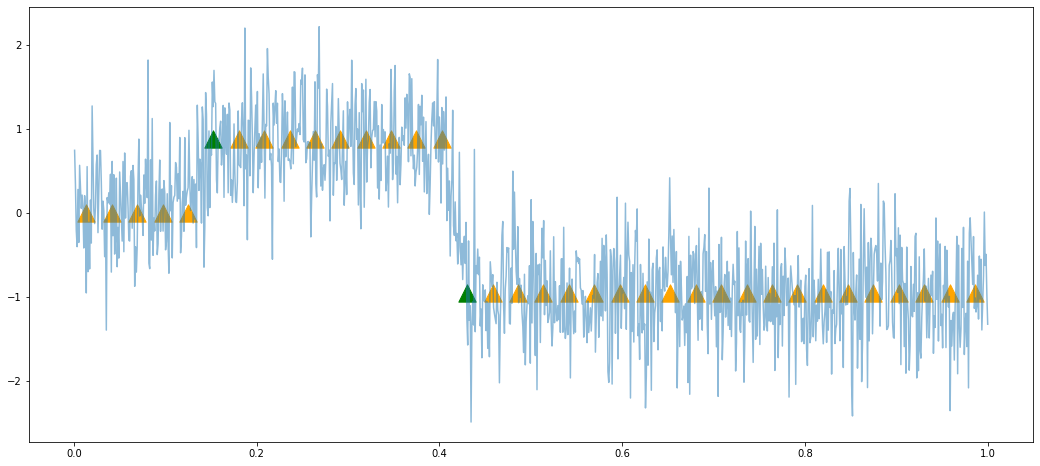

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(tp, y, alpha=0.5)
ax.scatter(knots_tp[is_jump>0], knots[is_jump>0], marker='^', s=300, color='green');
ax.scatter(knots_tp[is_jump==0], knots[is_jump==0], marker='^', s=300, color='orange');

Question here: can we create a pyro to connect the knots?

In [128]:
cp_stan_code = """
data {
  // response related
  int<lower=1> N_OBS;
  int<lower=1> N_KNOTS_LEV;
  vector[N_OBS] RESPONSE; 
  matrix[N_OBS, N_KNOTS_LEV] K_LEV;
  real<lower=0> SDY;
}
transformed data {
}

parameters {
  vector[N_KNOTS_LEV] lev_knot_drift;
  real<lower=0, upper=SDY> obs_scale;
}
transformed parameters {
  vector[N_OBS] lev;
  vector[N_OBS] yhat;  
  vector[N_KNOTS_LEV] lev_knot;
  lev_knot = cumulative_sum(lev_knot_drift);
  yhat = K_LEV * lev_knot;
}


model {
  lev_knot_drift ~ double_exponential(0, 3);
  obs_scale ~ cauchy(0, SDY)T[0, SDY];
  RESPONSE ~ normal(yhat, obs_scale);
}
"""
sm = pystan.StanModel(model_code=cp_stan_code)
with open('../models/cp_stan.pkl', 'wb') as f:
    pickle.dump(sm, f)
# with open('../models/cp_stan.pkl', 'rb') as f:
#     sm = pickle.load(f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9816419ef6fe4612b30c516cd68cc7a4 NOW.


Let's say we didn't know the true number of knots and assume some smaller number of knots.

In [129]:
N_KNOTS = 20

In [130]:
# normalize time
width = 1/N_KNOTS
tp = np.arange(1, T + 1)/ T
new_knots_tp = np.arange(width/2, 1, width)
K = sandwich_kernel(tp, new_knots_tp)

In [131]:
input_data = {
    'N_OBS': T,
    'N_KNOTS_LEV': N_KNOTS,
    'RESPONSE': y,
    'K_LEV': K,
    'SDY': np.std(y),
}

In [132]:
fit = sm.optimizing(data=input_data)
yhat = fit['yhat']

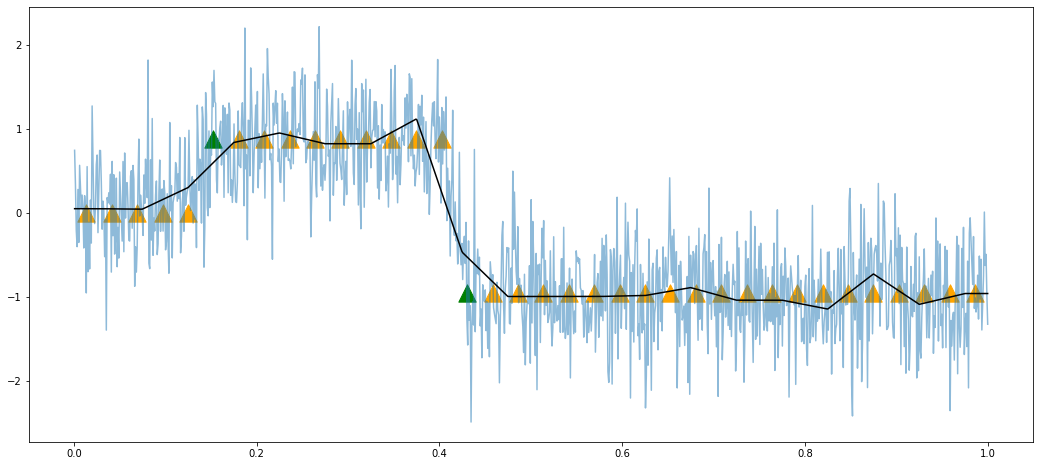

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(tp, y, alpha=0.5)
ax.scatter(knots_tp[is_jump>0], knots[is_jump>0], marker='^', s=300, color='green');
ax.scatter(knots_tp[is_jump==0], knots[is_jump==0], marker='^', s=300, color='orange');
ax.plot(tp, yhat, label='fitted', color='black');

# Numpyro test

In [23]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
import jax.numpy as jnp
from jax import random

In [18]:
N_KNOTS = 20

In [19]:
# normalize time
width = 1/N_KNOTS
tp = np.arange(1, T + 1)/ T
new_knots_tp = np.arange(width/2, 1, width)
K = sandwich_kernel(tp, new_knots_tp)

In [30]:
k = jnp.asarray(K)
sdy = np.std(y)

In [40]:
def model():
    with numpyro.plate("lev_plate", N_KNOTS):
        lev_knot_drift = numpyro.sample("lev_drift", dist.Laplace(0, 3))
    lev_knot = lev_knot_drift.cumsum(-1)
    yhat = numpyro.deterministic('yhat', k @ lev_knot)
    
    obs_scale = numpyro.sample("obs_scale", dist.HalfCauchy(sdy))
    
    with numpyro.plate("data", T):
         numpyro.sample("obs", dist.Normal(yhat, obs_scale), obs=y)


In [41]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:19<00:00, 204.99it/s, 127 steps of size 4.23e-02. acc. prob=0.93]


In [49]:
yhat = np.array(posterior_samples['yhat'])

In [50]:
yhat = np.median(yhat, axis=0)

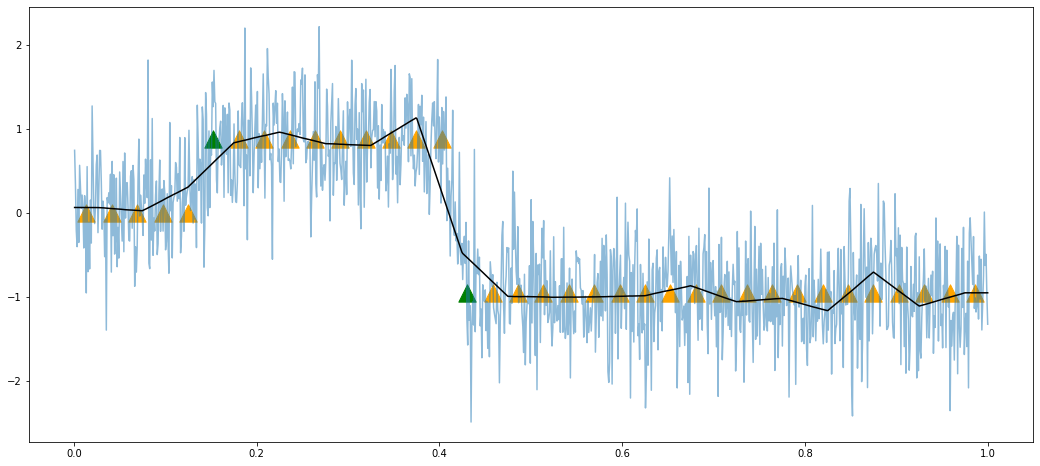

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(tp, y, alpha=0.5)
ax.scatter(knots_tp[is_jump>0], knots[is_jump>0], marker='^', s=300, color='green');
ax.scatter(knots_tp[is_jump==0], knots[is_jump==0], marker='^', s=300, color='orange');
ax.plot(tp, yhat, label='fitted', color='black');

# Pyro test

In [32]:
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoLowRankMultivariateNormal, AutoDelta
from pyro.optim import ClippedAdam
import pyro.distributions as dist
import torch
torch.set_default_tensor_type('torch.DoubleTensor')

In [75]:
k = torch.tensor(K, dtype=torch.double)
sdy = np.std(y)
n_knots = torch.tensor(N_KNOTS)
n_obs = torch.tensor(T)
obs = torch.tensor(y)

In [115]:
torch.set_default_tensor_type('torch.DoubleTensor')
def model():
    extract_out = {}
    with pyro.plate("lev_plate", n_knots):
        lev_knot_drift = pyro.sample("lev_drift", dist.Laplace(0, 3).to_event(0))
    lev_knot = lev_knot_drift.cumsum(-1)
    yhat = lev_knot @ k.transpose(-2, -1)
    
    obs_scale = pyro.sample("obs_scale", dist.HalfCauchy(sdy))
    
    with pyro.plate("data", n_obs):
         pyro.sample("obs", dist.Normal(yhat, obs_scale), obs=obs)
    extract_out.update({"yhat": yhat})
    return extract_out

In [123]:
num_steps=3000
num_samples=1000
message=1000
guide = AutoLowRankMultivariateNormal(model)
optim = ClippedAdam({
    "lr": 0.1,
})
elbo = Trace_ELBO(num_particles=100, vectorize_particles=True)
svi = SVI(model, guide, optim, elbo)

In [124]:
pyro.clear_param_store()
max_plate_nesting=2
for step in range(num_steps):
    loss = svi.step()
    if step % message == 0:
        scale_rms = guide._loc_scale()[1].detach().pow(2).mean().sqrt().item()
        print("step {: >4d} loss = {:0.5g}, scale = {:0.5g}".format(step, loss, scale_rms))

INFO:root:Guessed max_plate_nesting = 2


step    0 loss = 2535.8, scale = 0.1014
step 1000 loss = 928.94, scale = 0.067409
step 2000 loss = 939.22, scale = 0.077941


In [125]:
# Extract samples.
vectorize = pyro.plate("samples", num_sample, dim=-1 - max_plate_nesting)
with pyro.poutine.trace() as tr:
    samples = vectorize(guide)()
with pyro.poutine.replay(trace=tr.trace):
    samples.update(vectorize(model)())
# Convert from torch.Tensors to numpy.ndarrays.
extract = {
    name: value.detach().squeeze().numpy()
    for name, value in samples.items()
}

In [126]:
yhat = extract['yhat']
yhat = np.median(yhat, axis=0)

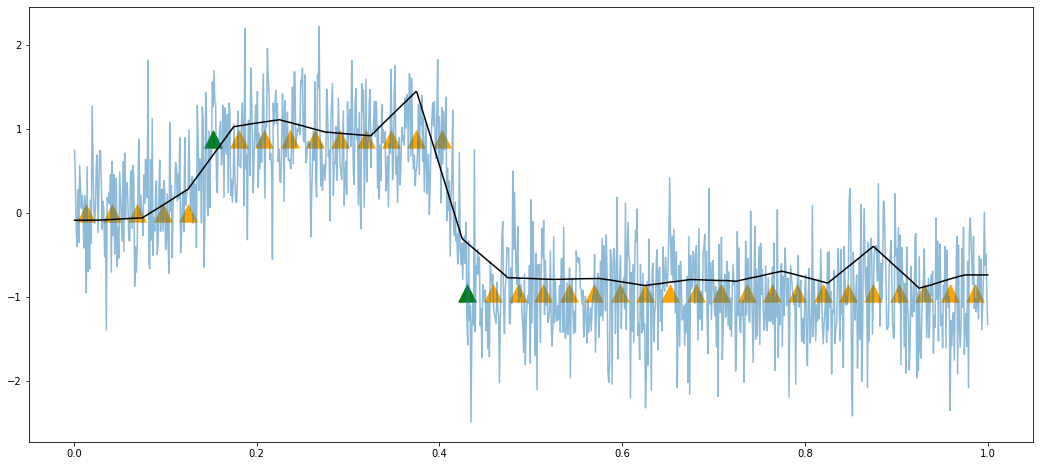

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(tp, y, alpha=0.5)
ax.scatter(knots_tp[is_jump>0], knots[is_jump>0], marker='^', s=300, color='green');
ax.scatter(knots_tp[is_jump==0], knots[is_jump==0], marker='^', s=300, color='orange');
ax.plot(tp, yhat, label='fitted', color='black');